In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle
import requests
import cloudpickle as cp
from urllib.request import urlopen

sys.path.insert(1, '../src/')
import helper_scripts.data_processor as data_processor
import helper_scripts.train as train

sys.path.insert(2, '../src/')

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

# Dataset Import

In [2]:
DATASET_URL = '../../Information/output/datav2.csv'

In [3]:
df_main = pd.read_csv(DATASET_URL, dtype = {'place.id': object})
df_main = data_processor.clean_df(df_main)
df_main = data_processor.aggregate_df(df_main)
df_main = data_processor.create_date_features(df_main)
df_main = data_processor.create_coordinates_features(df_main, file_path='../src/data/edges.geojson')
df_main = data_processor.create_weather_features(df_main, file_path='../src/data/weather_basel_2021-2022.csv')
df_main = data_processor.create_osm_features(df_main)
osm_columns = data_processor.create_osm_columns()
# Runtime ~3 minutes

In [4]:
# For purposes of saving execution time
#   Either retrain the models [True]
#   Or import already trained models [False]

retrain_models = True

litters = [2, 4, 1, 21, 19, 61] #, 39, 33, 3, 35, 8]

if retrain_models:
    models = train.make_models(df_main, litters)
    # Trianing time ~1 minute per litter
else:
    with open('dominik/models_for_testing/2022-08.pkl', 'rb') as f:
        models = pickle.load(f)  

The fitting took: 1.2 minutes
Litter 2 D2 Score: 0.672
#################################
The fitting took: 1.3 minutes
Litter 4 D2 Score: 0.6558
#################################
The fitting took: 1.5 minutes
Litter 1 D2 Score: 0.5953
#################################
The fitting took: 1.1 minutes
Litter 21 D2 Score: 0.6742
#################################
The fitting took: 1.1 minutes
Litter 19 D2 Score: 0.4725
#################################
The fitting took: 0.9 minutes
Litter 61 D2 Score: 0.4705
#################################


In [5]:
save_model = True

if save_model:
    with open('models_dictionary.pkl', 'wb') as f:
        pickle.dump(models, f)

# Prediction Testing

In [6]:
# Make a dataframe with predicted values

np.random.seed(42)
df_main_predicted = df_main.copy()
for key, model in models.items():
    predictions = model[0].predict(df_main_predicted)
    predictions = np.rint(predictions).astype(int)
    df_main_predicted[f"{key}_pred"] = predictions
columns_to_drop = ['Year', 'month', 'day', 'weekday', 'holiday', 'lat_north', 'lat_south', 'lon_east', 'lon_west', 'edge_length', 
        'temperature_max', 'temperature_min', 'temperature_mean', 'precipitation', 'snowfall', 'humidity_max', 'humidity_min', 
        'humidity_mean', 'cloud_coverage', 'wind_speed_max', 'wind_speed_min', 'wind_speed_mean']
columns_to_drop.extend(osm_columns)
df_main_predicted.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
# Runtime ~2 minutes

In [7]:
def aggregate_edges(df, litter, start=False, end=False):
    df_main_predicted = df
    df_test = df_main_predicted[['date_utc', 'edge_id', f'{litter}', f'{litter}_pred']]
    df_test = df_test.groupby(['edge_id'], as_index=False).agg({f'{litter}':'sum', f'{litter}_pred':'sum'})
    df_test = df_test.sample(n=14000, random_state=5).copy().reset_index(drop=True)

    agg_n_edges = []
    end = end+1
    if start < 2: start = 2
    for x in range(start, end):
        if (x<50) & (x%1==0): agg_n_edges.append(x)
        if (49<x<6500) & (x%50==0): agg_n_edges.append(x)
        #if (6500<x<7000) & (x%300==0): agg_n_edges.append(x)
        if (6500<x<13000) & (x%100==0): agg_n_edges.append(x)
        if (13000<x<14001) & (x%1000==0): agg_n_edges.append(x)

    ticks = []
    relative_error = []
    for n_edges in agg_n_edges:
        ###
        indices, df_indices = [], []
        for num in range(0, int(14000/n_edges)+1):
            indices.append(num)
        counter = 0
        while counter != 14000:
            for item in indices:
                df_indices.append(item)
                counter += 1
                if counter == 14000:
                    break
        df_indices = pd.Index(df_indices, dtype=int)
        ### df_test.index // n_edges

        df_loop = df_test.groupby(df_test.index // n_edges).agg({f'{litter}':'sum', f'{litter}_pred':'sum'})
        errors = []
        for row in df_loop.values:
            diff = abs(row[1] - row[0])
            if row[0] > 0:
                error = round((diff*100)/row[0], 8)
            else:
                 error = round((diff*100)/1, 8)
            errors.append(error)
        errors = np.array(errors)
        relative_error.append([n_edges, round(np.mean(errors), 2)])
        ticks.append([n_edges, errors])
    return ticks, relative_error

/var/folders/18/k719ypc560z2_2smxlh0k35c0000gn/T/ipykernel_83716/778629253.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(newXlabels)


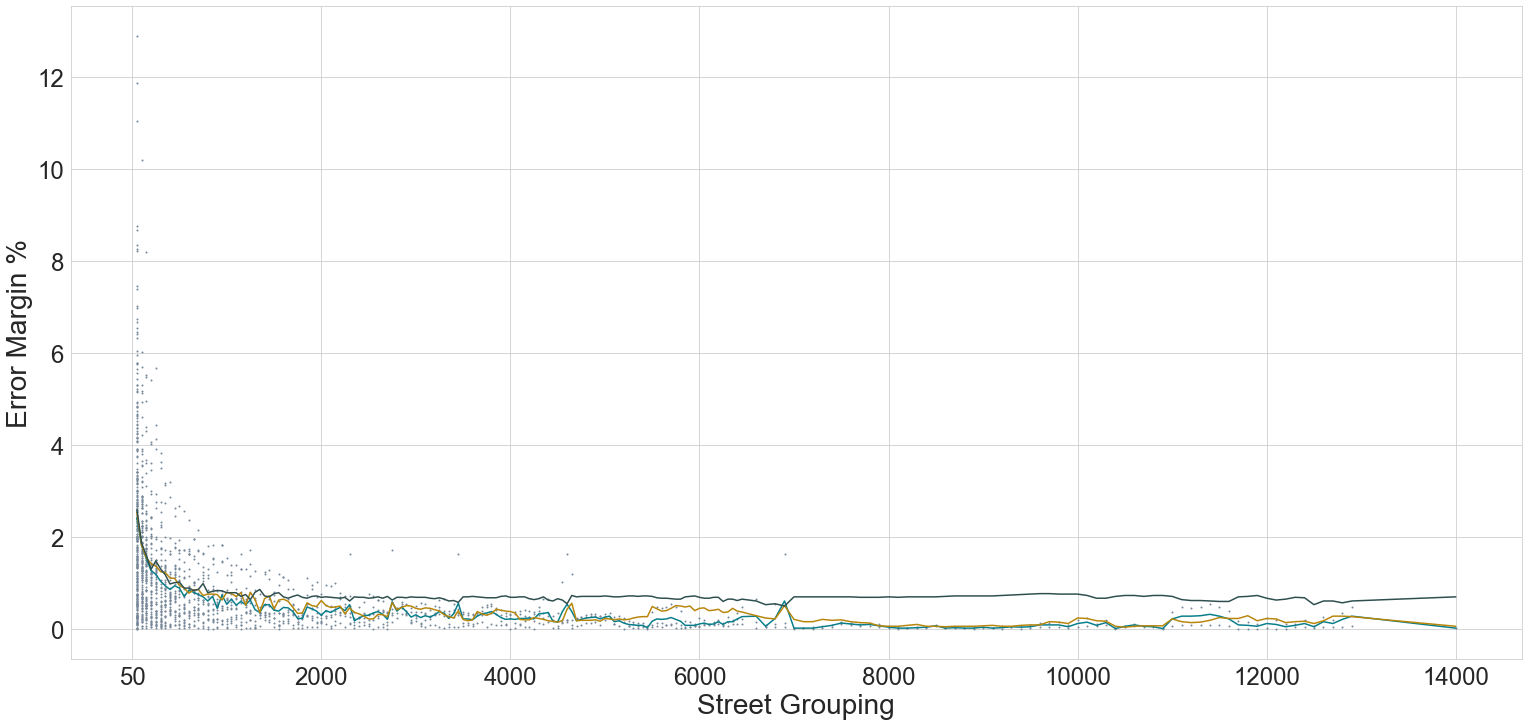

In [8]:
ticks1, relative_error1 = aggregate_edges(df_main_predicted, "1", start=50, end=14000)
ticks2, relative_error2 = aggregate_edges(df_main_predicted, "2", start=50, end=14000)
ticks4, relative_error4 = aggregate_edges(df_main_predicted, "4", start=50, end=14000)

relative_error1 = np.array(relative_error1)
relative_error2 = np.array(relative_error2)
relative_error4 = np.array(relative_error4)

fig, ax = plt.subplots(figsize=(26, 12))
ax.plot(relative_error1[:, 0], relative_error1[:, 1], color="#087E8B")
ax.plot(relative_error2[:, 0], relative_error2[:, 1], color="DarkGoldenRod")
ax.plot(relative_error4[:, 0], relative_error4[:, 1], color="DarkSlateGrey")
for array in ticks1:
  for tick in array[1]:
    #if (tick < 7):
      ax.scatter(x=array[0], y=tick, color="LightSlateGrey", s=1, alpha=1)
newXlabels = ['0', '50', '2000', '4000', '6000', '8000', '10000', '12000', '14000']
plt.gca().set_xticklabels(newXlabels)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Street Grouping', fontsize=28) 
plt.ylabel('Error Margin %', fontsize=28)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

columns_to_drop = ['total_litter', 'total_litter_ratio']
columns_to_drop.extend(data_processor.get_litter_columns(df_main))
X = df_main.drop(columns=columns_to_drop, errors='ignore')
y = df_main['1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

df_test = X_test.copy()
for key, model in models.items():
    predictions = model[0].predict(df_test)
    predictions = np.rint(predictions).astype(int)
    df_test[f"{key}_real"] = model[1]
    df_test[f"{key}_pred"] = predictions

columns_to_drop = ['Year', 'month', 'day', 'weekday', 'holiday', 'lat_north', 'lat_south', 'lon_east', 'lon_west', 'edge_length', 
        'temperature_max', 'temperature_min', 'temperature_mean', 'precipitation', 'snowfall', 'humidity_max', 'humidity_min', 
        'humidity_mean', 'cloud_coverage', 'wind_speed_max', 'wind_speed_min', 'wind_speed_mean']
columns_to_drop.extend(osm_columns)
df_test.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
# df_test = df_test[df_test['4_real'] < 8]
# df_test = df_test[df_test['4_pred'] > 30]
sample_num = 40
df_test = df_test.sample(n=sample_num).copy()

In [10]:
df_test.head(4)

,date_utc,edge_id,edge_osmid,osm_highway,2_real,2_pred,4_real,4_pred,1_real,1_pred,21_real,21_pred,19_real,19_pred,61_real,61_pred
91224,2022-02-01,"(1927745155, 262224427, 0)",182426824,secondary,0,6,3,2,4,4,0,0,0,0,0,0
305446,2022-04-04,"(1770756174, 3808692214, 0)",377495076,footway,0,5,1,4,0,2,0,0,0,0,0,0
49785,2022-01-18,"(7242168751, 7242168753, 0)",141360428,residential,39,69,0,2,0,4,0,0,0,0,0,0
9464,2022-01-06,"(107829354, 6814939393, 0)",25222207,residential,50,65,7,4,5,2,0,0,0,0,0,0


In [11]:
def make_scatter(df, y, x='edge_id'):
    y = str(y)
    y_real = f"{y}_real"
    y_pred = f"{y}_pred"

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title(f"Litter {y} {models[y][4]} - D2 Score: {models[y][2]}", pad=20)
    max_value = max(df[y_real].max(), df[y_pred].max())
    #ax.text(12, (max_value+10), f'D2 Score: {model[y][2]}', fontsize=15)
    ax.scatter(data=df, x=x, y=y_real, color='green', s=140)
    ax.scatter(data=df, x=x, y=y_pred, color='brown', s=70)
    for i in df.index:
      if df.loc[i, y_real] > df.loc[i, y_pred]:
        plt.vlines(x=df.loc[i, 'edge_id'], ymin= df.loc[i, y_pred], ymax= df.loc[i, y_real], colors='lightgrey')
      else:
        plt.vlines(x=df.loc[i, 'edge_id'], ymin= df.loc[i, y_real], ymax= df.loc[i, y_pred], colors='lightgrey')
    labels = [f'e{x}' for x in range(1, (sample_num+1))]
    ax.set_xticks(range(sample_num))
    ax.set_xticklabels(labels)
    plt.xlabel('Random Edge')
    plt.ylabel('Litter Count')
    ax.legend()
    plt.show()

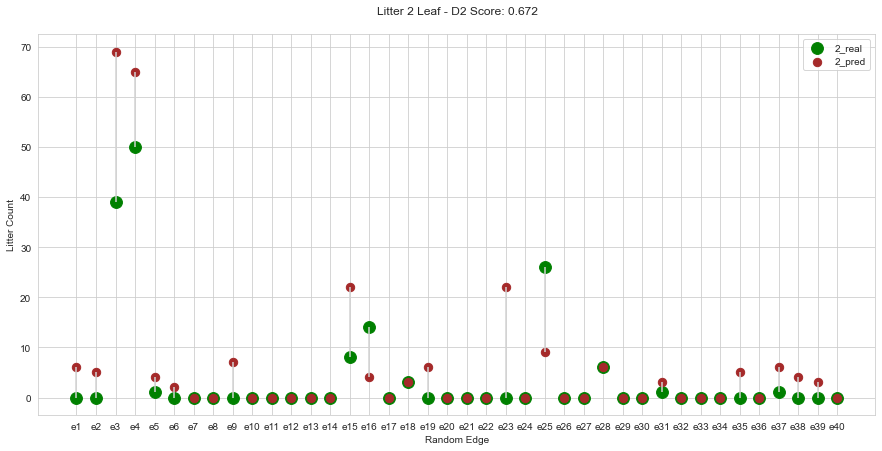

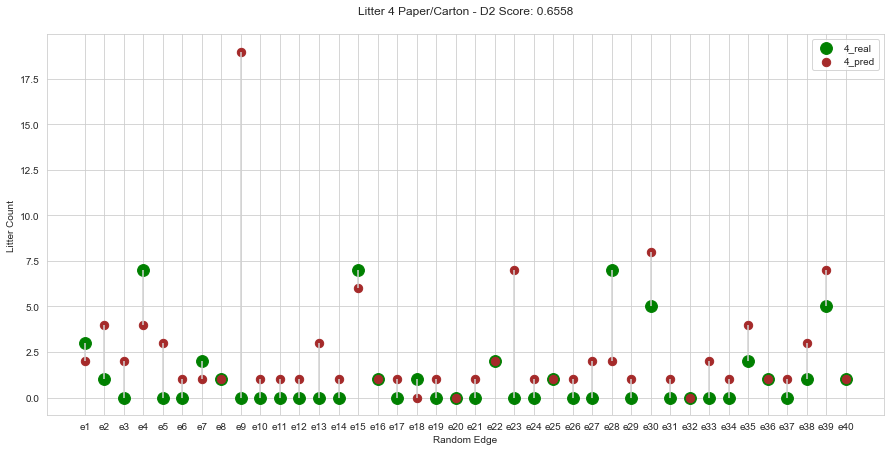

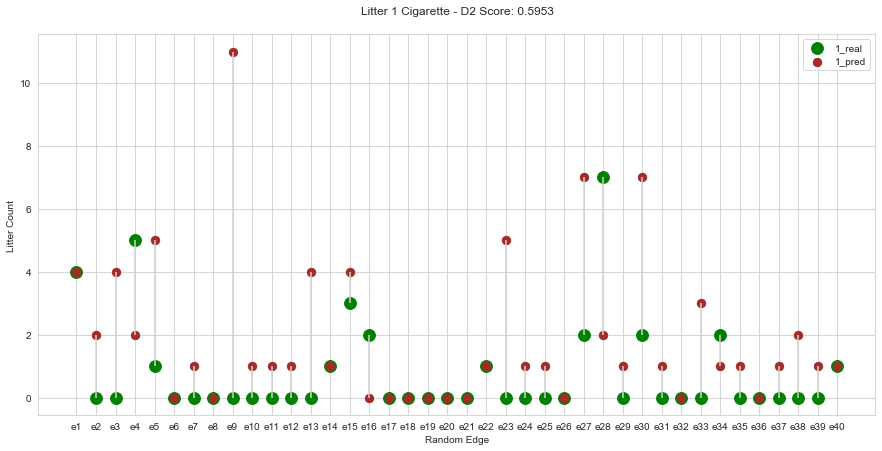

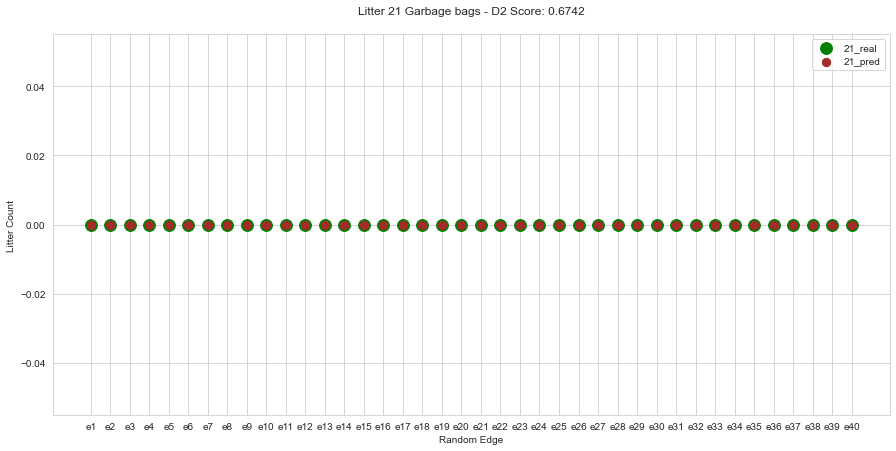

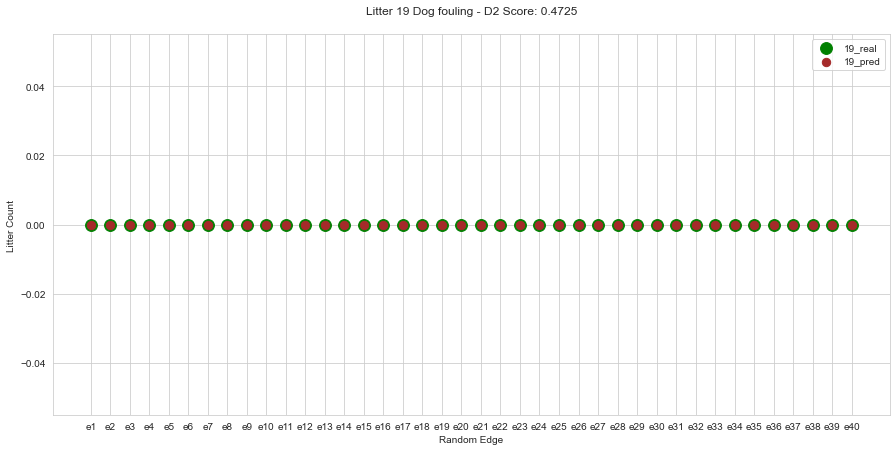

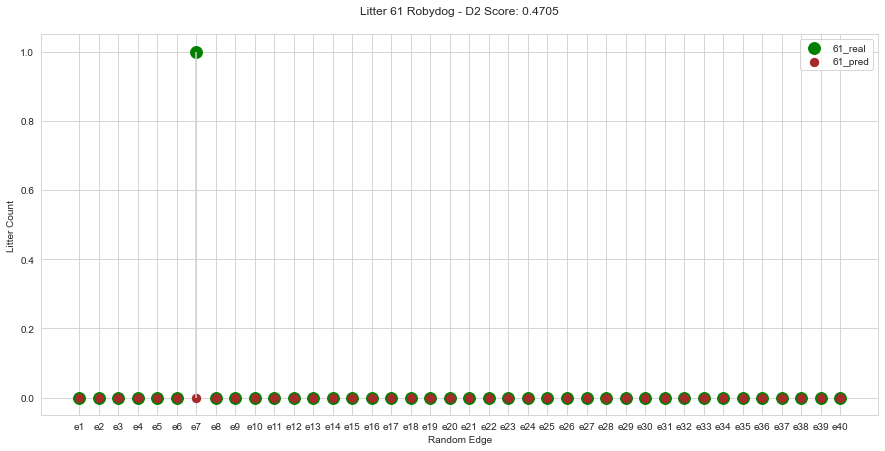

In [12]:
for litter in litters:
    make_scatter(df_test, litter)